In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path

import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import cv2

from pathlib import Path
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.manifold import TSNE
from keras.layers import Dropout, Embedding, LSTM

import tensorflow as tf
from tensorflow.keras import models, layers, Input, Model
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import VGG16
from os import listdir
from keras.layers.merge import add
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%matplotlib inline
sns.set()

#### Image directory

Python pathlib is used for easy handling of file paths.

In [ ]:
base_dir = '/content/drive/My Drive/Face Recognition/data/'
folder_list = os.listdir(base_dir)

In [ ]:
p = Path(base_dir)
traindir = p / 'train'
testdir = p / 'test'

#### Load training data

In [ ]:
def load_data(dir):
    X = []
    y = []
    for imgfolder in traindir.iterdir():
        if imgfolder.is_dir():
            for imgfile in imgfolder.glob('*.jpg'):
                img=cv2.imread(str(imgfile))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (200,200), interpolation = cv2.INTER_AREA)
                X.append(img)
                y.append(imgfolder.stem)
    X = np.asarray(X)
    y = np.asarray(y)    
    return X,y

In [ ]:
X_train, y_train = load_data(traindir)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(93, 200, 200, 3)
(93,)


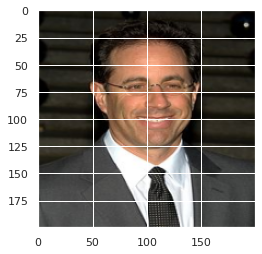

In [ ]:
plt.imshow(X_train[0]);

In [ ]:
X_test, y_test = load_data(testdir)

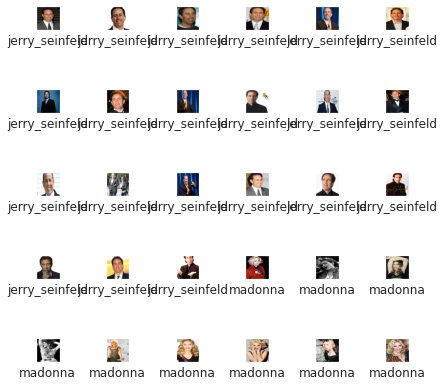

In [ ]:
#display training images and labels to make sure they lineup correctly
fig, ax = plt.subplots(5, 6, figsize=(6,6))
for i, axis in enumerate(ax.flat):
    axis.imshow(X_train[i], cmap= 'gray')
    axis.set(xticks = [], yticks=[], xlabel=y_train[i])
plt.tight_layout()

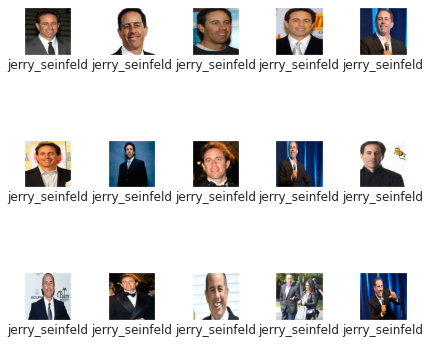

In [ ]:
#display test images and labels to make sure they lineup correctly
fig, ax = plt.subplots(3, 5, figsize=(6,6))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i])
    axi.set(xticks=[], yticks=[], xlabel=y_test[i])
plt.tight_layout()

In [ ]:
pd.Series(y_train).value_counts()

mindy_kaling      22
jerry_seinfeld    21
madonna           19
elton_john        17
ben_afflek        14
dtype: int64

#### Create training and test sets for Siamese network

In [ ]:
def make_pairs(X, y, img_count, lbl_count):
    
    # image1 contains the first image , image2 contains the second image, 
    # and lbl is 0 if the images are of same category otherwise 1

    image1 = []
    image2 = []
    lbl = []
     
    no_of_labels = len(np.unique(y))
    i = 0
    j = 0
    id2 = 0
    while i<len(X):
        min_label = pd.Series(y).value_counts()[no_of_labels-1]
        id2 = id2+1
        if id2 == 5:
            no_of_labels = no_of_labels-1
            i = i + min_label
            id2 = 0
        if i > 80:
            break
        
        id1 = 0
        i = i + 1
        j = 0
        if no_of_labels == 0:
            break
        while j < len(X):
            id1 = id1 + 1
            if id1 == min_label:
                id1 = 0
                j = j + min_label
            if j > 89:
                break
            '''if j==2:
                j = j + min_label
                print(j)
            if j> min_label + img_count:
                continue'''
            if y[i] == y[j]:
                if lbl.count(0) == lbl_count:
                    j = j + 1
                    break
                image1.append(X[i])
                image2.append(X[j])
                lbl.append(0)
            else:
                if lbl.count(1) == lbl_count:
                    j = j + 1
                    continue
                image1.append(X[i])
                image2.append(X[j])
                lbl.append(1)
            j = j + 1
            
    return image1, image2, lbl

In [ ]:
image1, image2, lbl = make_pairs(X_train, y_train, 3, 150)

In [ ]:
image1 = np.array(image1)
image2 = np.array(image2)
lbl = np.array(lbl)

In [ ]:
image1.shape

(300, 200, 200, 3)

In [ ]:
# check for equal number of 0, 1 labels
np.bincount(lbl)

array([150, 150])

#### Check that pairs of images in training set are correctly labeled.

1


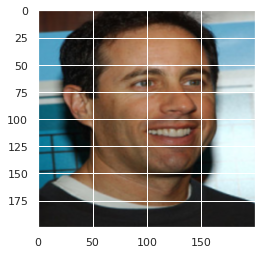

In [ ]:
i = np.random.choice(image1.shape[0])
print(lbl[i])
plt.imshow(image1[i], interpolation = 'bicubic');

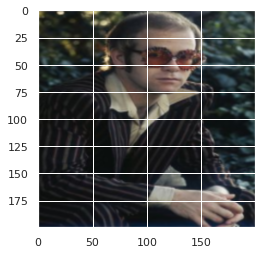

In [ ]:
plt.imshow(image2[i], interpolation = 'bicubic');

In [ ]:
image1_test, image2_test, lbl_test = make_pairs(X_test, y_test, 3, 40)

In [ ]:
image1_test = np.array(image1_test)
image2_test = np.array(image2_test)
lbl_test = np.array(lbl_test)

In [ ]:
np.bincount(lbl_test)

array([40, 40])

In [ ]:
K.clear_session()  # delete old models\n

#### Build embedding model

In [ ]:
# for a small data set we don't want too many parameters
input_shape = (200,200,3)
inputs = Input(input_shape)
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(100, activation='relu')
])

In [ ]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(5,5,8)),
    ])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 3, 3, 16)          1168      
                                                                 
Total params: 1,168
Trainable params: 1,168
Non-trainable params: 0
_________________________________________________________________


#### Build Siamese network

In [ ]:
left_input = Input((200,200,3))
right_input = Input((200,200,3))

encoded_l = model(left_input)
encoded_r = model(right_input)

L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

In [ ]:
siamese_net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 100)          7383044     input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 100)          0           sequential[0][0]             

In [ ]:
siamese_net.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])

In [ ]:
siamese_net.fit([image1,image2],lbl,
          batch_size=32,
          epochs=5,validation_data=([image1_test,image2_test],lbl_test))

Epoch 1/5
10/10 [==============================] - 24s 2s/step - loss: 71.6585 - accuracy: 0.5767 - val_loss: 26.7524 - val_accuracy: 0.4625
Epoch 2/5
10/10 [==============================] - 23s 2s/step - loss: 6.4574 - accuracy: 0.6833 - val_loss: 2.3978 - val_accuracy: 0.6125
Epoch 3/5
10/10 [==============================] - 23s 2s/step - loss: 1.0119 - accuracy: 0.7900 - val_loss: 0.3148 - val_accuracy: 0.8250
Epoch 4/5
10/10 [==============================] - 23s 2s/step - loss: 0.2900 - accuracy: 0.8533 - val_loss: 0.4379 - val_accuracy: 0.8375
Epoch 5/5
10/10 [==============================] - 23s 2s/step - loss: 0.2104 - accuracy: 0.9067 - val_loss: 0.1648 - val_accuracy: 0.9125


#### Try trained network on random pairs of images in test set

In [ ]:
# label value 0 means "same"
i = np.random.choice(image1_test.shape[0])
siamese_net.predict([np.array([image1_test[i]]), np.array([image2_test[i]])])

array([[0.8483325]], dtype=float32)

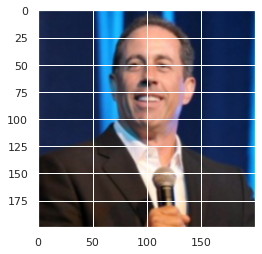

In [ ]:
plt.imshow(image1_test[i], interpolation = 'bicubic');

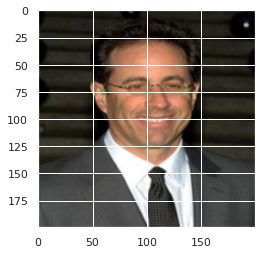

In [ ]:
plt.imshow(image2_test[i], interpolation = 'bicubic');